This file cleans the event data and the time series data as well as calculates the surprise score on a rolling basis.

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import skew, kurtosis
from matplotlib.colors import to_rgba

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Your path here.
path = '/content/drive/MyDrive/CFEM Greenmantle Project/Data/Event Data/'

# Event Data


## Data Cleaning

In [4]:
# Read the csv data file.
event = pd.read_csv(path+"all_events.csv",index_col=False)

In [5]:
# Convert the column to datetime with minute accuracy
event['Event_Time'] = pd.to_datetime(event['datetime']).dt.floor('min')
del event['datetime']

### function: cleaning(x)

In [6]:
# Change the data in str format to numeric

warnings.filterwarnings('ignore')
def cleaning(x):
  ''' This function cleans the data in str format to numeric.'''
  if isinstance(x, str):
    # If the data is a string, try to convert it to a number. If failed, drop it.
    x = x.replace(',', '')
    x = x.replace('$', '')
    # x = x.replace('--', '')
    if '--' in x: return x

    try: return float(x)
    except:
      if x[-1] == "%":
        try: return float(x[:-1])/100
        except:
          x = x[:-1]
          if x[-1] == "K" or x[-1] == "k": return float(x[:-1])*1000
          if x[-1] == "M": return float(x[:-1])*1000000
          if x[-1] == "B": return float(x[:-1])*1000000000
          if x[-1] == "T": return float(x[:-1])*1000000000000
      if x[-1] == "K" or x[-1] == "k": return float(x[:-1])*1000
      if x[-1] == "M": return float(x[:-1])*1000000
      if x[-1] == "B": return float(x[:-1])*1000000000
      if x[-1] == "T": return float(x[:-1])*1000000000000

  else: return x

  return np.nan

In [7]:
# Apply the cleaning function to various columns.
event["Consensus"] = event["Consensus"].apply(cleaning)
event["Actual"] = event["Actual"].apply(cleaning)
event["Forecast"] = event["Forecast"].apply(cleaning)

## Surprise score calculation

In [8]:
# Calculate the initial surprise score.
event["Surprise"] = event.apply(lambda row: (row['Actual'] - row['Forecast']) if pd.isna(row['Consensus']) else (row['Actual'] - row['Consensus']), axis=1)

### function: rolling_Z_score(df, col, group_by=['Event'], window_size='1000D', min_periods=1)


In [9]:
def rolling_Z_score(df, col, group_by=['Event'], window_size='1000D', min_periods=1):
    '''This function groups the dataframe by the given group_by list, calculates the Z-score of a column in each group,
       drops the outliers (Z-score beyond ±3), and then recalculates the Z-score for the remaining data.'''

    df['Event_Time'] = pd.to_datetime(df['Event_Time'])

    # First group the dataframe by the specified group_by list
    grouped = df.groupby(group_by, group_keys=False)  # group_keys=False prevents multi-level indexing

    def calc_rolling_z_score(group, window_size, min_periods):
        data = group.set_index('Event_Time')
        data = data.sort_index()

        rolling_mean = data[col].rolling(window=window_size, min_periods=min_periods).mean()
        rolling_std = data[col].rolling(window=window_size, min_periods=min_periods).std()

        rolling_std = rolling_std.fillna(1)

        # Calculate the Z-score
        data['Z_score'] = ((data[col] - rolling_mean) / rolling_std).fillna(0)

        # Filter out outliers with Z-scores outside the range of [-3, 3]
        group_filtered = data[(data['Z_score'].abs() <= 3)]

        # Drop the Z_score column
        group_filtered = group_filtered.drop(columns=['Z_score'])

        # Recalculate the rolling mean and standard deviation after removing outliers
        rolling_mean = group_filtered[col].rolling(window=window_size, min_periods=min_periods).mean()
        rolling_std = group_filtered[col].rolling(window=window_size, min_periods=min_periods).std()

        rolling_std = rolling_std.fillna(1)

        # Recalculate the Z-score for the filtered data
        group_filtered['Z_score_Surprise_rolling'] = ((group_filtered[col] - rolling_mean) / rolling_std).fillna(0)

        group_filtered.reset_index(inplace=True)

        return group_filtered

    # Apply the Z-score calculation function to each group
    filtered_df = grouped.apply(calc_rolling_z_score, window_size=window_size, min_periods=min_periods)

    # Reset the index of the filtered dataframe
    filtered_df.reset_index(inplace=True, drop=True)

    # Convert Event_Time back to str
    filtered_df['Event_Time'] = filtered_df['Event_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Remove the group_by columns from the index if they become part of a multi-index
    filtered_df = filtered_df.reset_index(drop=True)

    return filtered_df

In [17]:
# Calculate Surprise score on a rolling basis
filtered_event = rolling_Z_score(event, 'Surprise', group_by=['Event'], window_size='1000D', min_periods=1)
filtered_event_cleaned = filtered_event.dropna(subset=['Z_score_Surprise_rolling'])
filtered_event_cleaned.head()

,Event_Time,Unnamed: 0,Event,Reference,Event_Type,Actual,Previous,Consensus,Forecast,Event_Url,source,year,Surprise,Z_score_Surprise_rolling
0,2014-10-08 13:00:00,11,10-Year Note Auction,NaN,Bond Auctions,0.02381,2.535%,NaN,0.0241,https://tradingeconomics.com/united-states/gov...,NaN,2014,-0.00029,0.000000
1,2014-11-12 13:00:00,34,10-Year Note Auction,NaN,Bond Auctions,0.02365,2.381%,NaN,0.0237,https://tradingeconomics.com/united-states/gov...,NaN,2014,-0.00005,0.707107
2,2014-12-10 13:00:00,53,10-Year Note Auction,NaN,Bond Auctions,0.02214,2.365%,NaN,NaN,https://tradingeconomics.com/united-states/gov...,NaN,2014,NaN,0.000000
3,2015-01-13 13:00:00,8,10-Year Note Auction,NaN,Bond Auctions,0.01930,2.214%,NaN,NaN,https://tradingeconomics.com/united-states/gov...,NaN,2015,NaN,0.000000
4,2015-02-11 13:00:00,27,10-Year Note Auction,NaN,Bond Auctions,0.02000,1.930%,NaN,NaN,https://tradingeconomics.com/united-states/gov...,NaN,2015,NaN,0.000000


In [18]:
# Check the number of events in each event type.
def
filtered_event_cleaned.groupby('Event_Type').size().reset_index(name='Count')

,Event_Type,Count
0,Bond Auctions,3295
1,Business Confidence,4868
2,Consumer Sentiment,2423
3,Foreign Trade,721
4,GDP Growth,201
5,Government,122
6,Housing Market,4280
7,Interest Rate,2902
8,Labour Market,3054
9,Prices & Inflation,2857


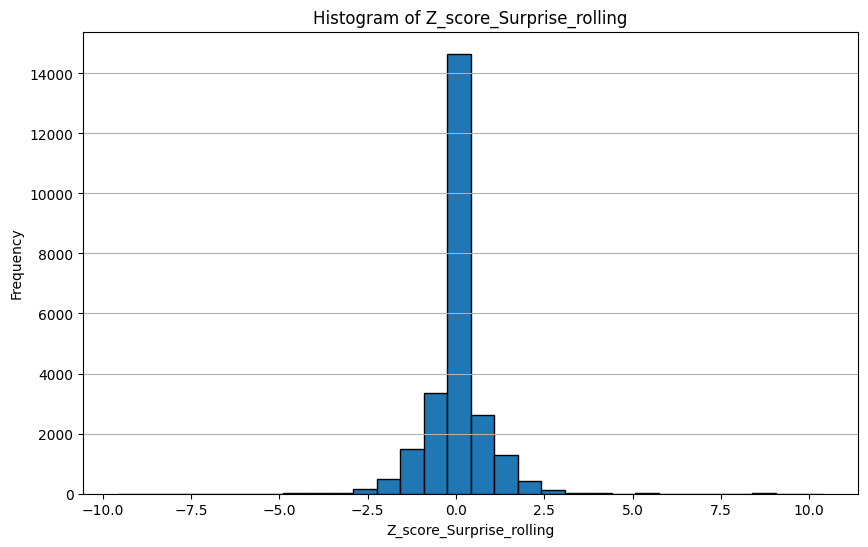

In [19]:
# Check the distribution of the rolling Z score of the surprise score.
plt.figure(figsize=(10, 6))
plt.hist(filtered_event_cleaned['Z_score_Surprise_rolling'], bins=30, edgecolor='black')
plt.title('Histogram of Z_score_Surprise_rolling')
plt.xlabel('Z_score_Surprise_rolling')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [13]:
# Adjust the used columns
filtered_event_cleaned = filtered_event_cleaned[['Event', 'Event_Time', 'Event_Type', 'Z_score_Surprise_rolling', 'year']]
filtered_event_cleaned.head()

,Event,Event_Time,Event_Type,Z_score_Surprise_rolling,year
0,10-Year Note Auction,2014-10-08 13:00:00,Bond Auctions,0.000000,2014
1,10-Year Note Auction,2014-11-12 13:00:00,Bond Auctions,0.707107,2014
2,10-Year Note Auction,2014-12-10 13:00:00,Bond Auctions,0.000000,2014
3,10-Year Note Auction,2015-01-13 13:00:00,Bond Auctions,0.000000,2015
4,10-Year Note Auction,2015-02-11 13:00:00,Bond Auctions,0.000000,2015


In [ ]:
# Output the cleaned event data to another csv file.
filtered_event_cleaned.to_csv(path+"event_data_cleaned.csv", index=False)